Text classification is the task of assigning a set of predefined categories to open-ended text. Text classifiers can be used to organize, structure, and categorize pretty much any kind of text – from documents, medical studies and files, and all over the web.We will classify the text into 9 categories.The 9 categories are:
- computer       
- science        
- politics       
- sport          
- automobile     
- religion        
- medicine       
- sales           
- alt.atheism

# Import Libraries

Let's first import all the required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from time import time
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix, f1_score
from statistics import mean
import pickle
from tensorflow import keras
from keras import layers
from keras import losses
from keras import utils
from keras.layers.experimental.preprocessing import TextVectorization
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.models import load_model
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# Load Dataset

We will going to use the 20 news group dataset.Let's load the dataset in dataframe

In [2]:
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label

In [3]:
# first few rows of the dataset
df.head()

,text,source,label
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


We will later use the label enocder to convert the labels (categorical value) into numeric value.So now, we will drop that column

In [4]:
# drop source column
df.drop(['source'],axis=1,inplace=True)

Let's see the count of each label

In [5]:
# value count
df['label'].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: label, dtype: int64

In our dataset we have very less data in a each categorical label and there are 20 categories which are too much.We will combine the sub-categories

- So in politics we have mideast, guns and misc sub-topics we will replace all to politics
- We have sub-categories in sports, we will going to replace this also into sports
- We have two sub categories in religion, we will replace them to one
- We are going to make 9 categories in all

In [6]:
# replace to politics
df['label'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'},inplace=True)
                    
# replace to sport
df['label'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
                    
# replace to religion
df['label'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion'},inplace=True)
                    
# replace to computer
df['label'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'},inplace=True)  
# replace to sales
df['label'].replace({'misc.forsale':'sales'},inplace=True)

# replace to automobile
df['label'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)

# replace to science
df['label'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'},inplace=True)

# replace to medicine
df['label'].replace({'sci.med':'medicine'},inplace=True)

Let's see the number of unique targets 

In [7]:
# number of targets
df['label'].nunique()

9

In [8]:
# value count
df['label'].value_counts()

computer       2936
science        1779
politics       1575
sport          1197
automobile     1192
religion        976
medicine        594
sales           585
alt.atheism     480
Name: label, dtype: int64

We are going to make a number of words column in which there is the number of words in a particular text

In [9]:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))
df.head()

,text,label,Number_of_words
0,I was wondering if anyone out there could enli...,automobile,91
1,A fair number of brave souls who upgraded thei...,computer,90
2,"well folks, my mac plus finally gave up the gh...",computer,307
3,\nDo you have Weitek's address/phone number? ...,computer,15
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72


Check the basic stats of number of words, like maximum, minimum, average number of words

In [10]:
# basic stats
df['Number_of_words'].describe()

count    11314.000000
mean       185.827382
std        523.971647
min          0.000000
25%         40.000000
50%         83.000000
75%        167.000000
max      11765.000000
Name: Number_of_words, dtype: float64

So the maximum number of words in our dataset is 11,765.Let's have a look at it

In [11]:
df[df['Number_of_words']==11765]

,text,label,Number_of_words
9192,Since electrical wiring questions do turn up f...,science,11765


So maximu number of words text is belongs to electronics category.In our dataset we have some rows where there are no text at all i.e. the number of words is 0.We will drop those rows

In [12]:
no_text = df[df['Number_of_words']==0]
print(len(no_text))

# drop these rows
df.drop(no_text.index,inplace=True)

300


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

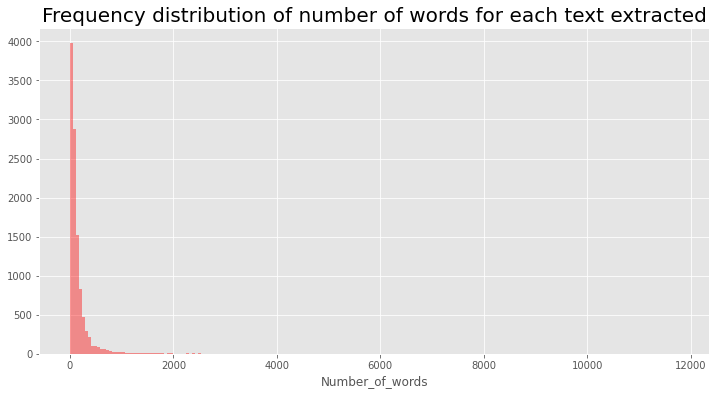

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

# Data Pre-Processing

Now it's time to clean our dataset, we will lower the text, remove the text in square brackets, remove links and remove words containing numbers

In [14]:
# cleaning the text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to  datasets
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# updated text
df['cleaned_text'].head()

0    i was wondering if anyone out there could enli...
1    a fair number of brave souls who upgraded thei...
2    well folks my mac plus finally gave up the gho...
3    do you have weiteks addressphone number  id li...
4    from article  by tombakerworldstdcom tom a bak...
Name: cleaned_text, dtype: object

Let's convert our cleaned text into tokens

In [15]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
df['tokens'] = df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))
df.head()

,text,label,Number_of_words,cleaned_text,tokens
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[i, was, wondering, if, anyone, out, there, co..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[a, fair, number, of, brave, souls, who, upgra..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[well, folks, my, mac, plus, finally, gave, up..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[do, you, have, weiteks, addressphone, number,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[from, article, by, tombakerworldstdcom, tom, ..."


Stopwords are those english words which do not add much meaning to a sentence.They are very commonly used words and we do not required those words. So we can remove those stopwords

In [16]:
# stopwords
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

Let's check number of stopwords in nltk library

In [17]:
len(stopwords.words('english'))

179

Now we are going to remome the stopwords from the sentences

In [18]:
# removing stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 
df['stopwordremove_tokens'] = df['tokens'].apply(lambda x : remove_stopwords(x))
df.head()

,text,label,Number_of_words,cleaned_text,tokens,stopwordremove_tokens
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u..."


It's time to do lemmatization

In [19]:
# lemmatization
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

df['lemmatized_text'] = df['stopwordremove_tokens'].apply(lem_word)
df.head()

,text,label,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw...","[wondering, anyone, could, enlighten, car, saw..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo...","[fair, number, brave, soul, upgraded, si, cloc..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,...","[well, folk, mac, plus, finally, gave, ghost, ..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,...","[weiteks, addressphone, number, id, like, get,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u...","[article, tombakerworldstdcom, tom, bakermy, u..."


Now we are going to combine our text, this is our final text

In [20]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

df['final_text'] = df['lemmatized_text'].apply(lambda x : combine_text(x))
df.head()

,text,label,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text,final_text
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw...","[wondering, anyone, could, enlighten, car, saw...",wondering anyone could enlighten car sawthe da...
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo...","[fair, number, brave, soul, upgraded, si, cloc...",fair number brave soul upgraded si clock oscil...
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,...","[well, folk, mac, plus, finally, gave, ghost, ...",well folk mac plus finally gave ghost weekend ...
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,...","[weiteks, addressphone, number, id, like, get,...",weiteks addressphone number id like get inform...
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u...","[article, tombakerworldstdcom, tom, bakermy, u...",article tombakerworldstdcom tom bakermy unders...


So we have cleaned the dataset and remove stopwords, it's possible that there are rows in which the text length is 0.We will find those rows and remove them

In [21]:
df['Final_no_of_words'] = df['final_text'].apply(lambda x:len(str(x).split()))
df.head()

,text,label,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text,final_text,Final_no_of_words
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw...","[wondering, anyone, could, enlighten, car, saw...",wondering anyone could enlighten car sawthe da...,42
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo...","[fair, number, brave, soul, upgraded, si, cloc...",fair number brave soul upgraded si clock oscil...,52
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,...","[well, folk, mac, plus, finally, gave, ghost, ...",well folk mac plus finally gave ghost weekend ...,149
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,...","[weiteks, addressphone, number, id, like, get,...",weiteks addressphone number id like get inform...,8
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u...","[article, tombakerworldstdcom, tom, bakermy, u...",article tombakerworldstdcom tom bakermy unders...,35


In [22]:
# basic stats
df['Final_no_of_words'].describe()

count    11014.000000
mean        93.284547
std        269.498465
min          0.000000
25%         21.000000
50%         42.000000
75%         83.000000
max       6433.000000
Name: Final_no_of_words, dtype: float64

In [23]:
# number of rows with text lenth = 0
print(len(df[df['Final_no_of_words']==0]))

# drop those rows
df.drop(df[df['Final_no_of_words']==0].index,inplace=True)

20


Now our text has been cleaned, we will convert the labels into numeric values using LableEncoder()

In [24]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])
  
df['target'].unique()

array([1, 2, 7, 4, 3, 5, 6, 0, 8])

# Dependent and Independent Variable

In [25]:
# dependent and independent variable
X = df['final_text']
y = df['target']

In [26]:
X.shape,y.shape

((10994,), (10994,))

# Bag-of-Words

CountVectorizer is used to transform a given text into a vector on the basis of the frequency(count) of each word that occurs in the entire text.It involves counting the number of occurences each words appears in a document(text)

In [27]:
count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(X)
print(count_vector[0].todense())

[[0 0 0 ... 0 0 0]]


# Tf-Idf

Tf-Idf stands for Term Frequency-Inverse document frequency.It is a techinque to quantify a word in documents,we generally compute a weight to each word which signifies the importance of the word which signifies the importance of the word in the document and corpus

In [28]:
tfidf_vectorizer = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
tfidf = tfidf_vectorizer.fit_transform(X)
print(tfidf[0].todense())

[[0. 0. 0. ... 0. 0. 0.]]


# SMOTE technique to balance the dataset

So we can clearly see that our dataset is imbalanced dataset.We will use SMOTE technique to balance the dataset.SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.The algorithm helps to overcome the overfitting problem posed by random sampling. 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

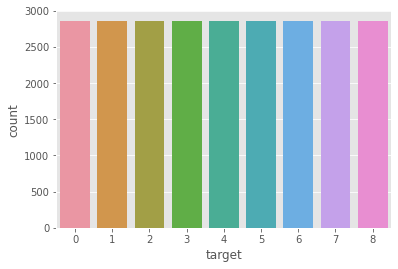

In [29]:
# count vector
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(count_vector,y)


sns.countplot(Y_smote)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

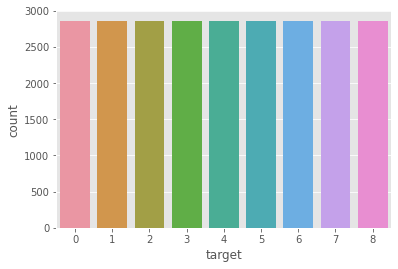

In [30]:
# tfidf
smote = SMOTE(random_state = 402)
X_smote_tfidf, Y_smote_tfidf = smote.fit_resample(tfidf,y)

sns.countplot(Y_smote_tfidf)

## Train-Test Split

In [31]:
# train-test split countvector
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size = 0.20, random_state = 0)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((20584, 137337), (5147, 137337), (20584,), (5147,))

In [32]:
# train-test split tfidf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_smote_tfidf, Y_smote_tfidf , test_size = 0.20, random_state = 0)

In [33]:
training_time_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                          'logistic_reg':0,'logistic_reg_tfidf':0}
prediction_time_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                            'logistic_reg':0,'logistic_reg_tfidf':0}
accuracy_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                     'logistic_reg':0,'logistic_reg_tfidf':0}

# Logistic Regression

In [34]:
# on countvector
lg = LogisticRegression(C = 1.0)
#Fitting the model 
t0=time()
lg.fit(X_train,y_train)
training_time_container['logistic_reg']=time()-t0


# Predicting the Test set results
t0 = time()
y_pred_lg = lg.predict(X_test)
prediction_time_container['logistic_reg']=time()-t0

lg_test_accuracy =  accuracy_score(y_test,y_pred_lg)
accuracy_container['logistic_reg'] = lg_test_accuracy

print('Training Accuracy : ', accuracy_score(y_train,lg.predict(X_train)))
print('Testing Accuracy: ',lg_test_accuracy)
print("Training Time: ",training_time_container['logistic_reg'])
print("Prediction Time: ",prediction_time_container['logistic_reg'])
print(confusion_matrix(y_test,y_pred_lg))

Training Accuracy :  0.8101923824329577
Testing Accuracy:  0.6790363318437925
Training Time:  37.385868549346924
Prediction Time:  0.01749396324157715
[[356   6   2  12   9  21 176   2   5]
 [ 21 344   9  29   6   9 128  15  10]
 [ 10  10 433   7   3   6  30  33   1]
 [  9   4   7 396   4   4 132   7   6]
 [ 26  26   3  22 348  20  93  11   7]
 [ 31   9   7  18  21 346 118   4   6]
 [  4   8  15   4   0   4 539   9   8]
 [ 17  29  47  11  19  10  87 351  10]
 [ 14  17   7   5   7   5 154   6 382]]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
# on tfidf
lg = LogisticRegression(C = 1.0)
#Fitting the model 
t0=time()
lg.fit(X_train_tfidf,y_train_tfidf)
training_time_container['logistic_reg_tfidf']=time()-t0

# Predicting the Test set results
t0=time()
ypred_lg_tf = lg.predict(X_test_tfidf)
prediction_time_container['logistic_reg_tfidf']=time()-t0

lg_test_accuracy_tf  = accuracy_score(y_test_tfidf,ypred_lg_tf)
accuracy_container['logistic_reg_tfidf'] = lg_test_accuracy_tf

print('Training Accuracy: ', accuracy_score(y_train_tfidf,lg.predict(X_train_tfidf)))
print('Testing Accuracy: ', lg_test_accuracy_tf)
print("Training Time: ",training_time_container['logistic_reg_tfidf'])
print("Prediction Time: ",prediction_time_container['logistic_reg_tfidf'])
print(confusion_matrix(y_test,ypred_lg_tf))

Training Accuracy:  0.9605518849591916
Testing Accuracy:  0.9215076743734214
Training Time:  41.4539589881897
Prediction Time:  0.02503037452697754
[[577   2   1   0   5   2   0   2   0]
 [  0 520   3   0   7   4   2   7  28]
 [  2   6 479   2   2   1  18  12  11]
 [  0   1   4 542   0   0   0   2  20]
 [  3   6   2   2 502   6   2   4  29]
 [  6   3   2   1  16 494   0   2  36]
 [  0   3  10   0   0   0 547   0  31]
 [  1  10  33   0  11   5   6 501  14]
 [  0   3   7   0   4   1   0   1 581]]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Multinomial Naive Bayes

In [36]:
# on countvector
nb = MultinomialNB()
#Fitting the model 
t0=time()
nb.fit(X_train,y_train)
training_time_container['mnb_naive_bayes']=time()-t0


# Predicting the Test set results
t0 = time()
y_pred_nb = nb.predict(X_test)
prediction_time_container['mnb_naive_bayes']=time()-t0

mnb_test_accuracy =  accuracy_score(y_test,y_pred_nb)
accuracy_container['mnb_naive_bayes'] = mnb_test_accuracy

print('Training Accuracy : ', accuracy_score(y_train,nb.predict(X_train)))
print('Testing Accuracy: ',mnb_test_accuracy)
print("Training Time: ",training_time_container['mnb_naive_bayes'])
print("Prediction Time: ",prediction_time_container['mnb_naive_bayes'])
print(confusion_matrix(y_test,y_pred_nb))

Training Accuracy :  0.6573066459385931
Testing Accuracy:  0.5919953370895668
Training Time:  0.05366396903991699
Prediction Time:  0.007699728012084961
[[205   1 191   3  72 102   0   9   6]
 [  2 298 136   7  74  25   5  17   7]
 [  0   1 494   3   7   3   4  21   0]
 [  2   2 155 320  43  21   5  16   5]
 [  3   7  93   4 411  20   2  12   4]
 [ 10   0 123   0  51 364   1  10   1]
 [  0  12 284   3  21   1 216  42  12]
 [  3  11 141   2  45   6   4 365   4]
 [  3   1 157   1  37  13   5   6 374]]


In [37]:
# on tfidf
nb = MultinomialNB()
#Fitting the model 
t0=time()
nb.fit(X_train_tfidf,y_train_tfidf)
training_time_container['mnb_naive_bayes_tfidf']=time()-t0

# Predicting the Test set results
t0=time()
ypred_nb_tf = nb.predict(X_test_tfidf)
prediction_time_container['mnb_naive_bayes_tfidf']=time()-t0

mnb_tfidf_test_accuracy = accuracy_score(y_test_tfidf,ypred_nb_tf)
accuracy_container['mnb_naive_bayes_tfidf'] = mnb_tfidf_test_accuracy 


print('Training Accuracy: ', accuracy_score(y_train_tfidf,nb.predict(X_train_tfidf)))
print('Testing Accuracy: ',mnb_tfidf_test_accuracy )
print("Training Time: ",training_time_container['mnb_naive_bayes_tfidf'])
print("Prediction Time: ",prediction_time_container['mnb_naive_bayes_tfidf'])
print(confusion_matrix(y_test,ypred_nb_tf))

Training Accuracy:  0.9689564710454722
Testing Accuracy:  0.9362735574120847
Training Time:  0.06893253326416016
Prediction Time:  0.013717174530029297
[[582   0   0   0   1   6   0   0   0]
 [ 11 528   5   2   7   7   3   6   2]
 [  8   4 477   5   2   3  22  12   0]
 [  1   0   5 561   0   0   0   1   1]
 [ 10   4   3   3 517  12   1   4   2]
 [ 20   0   2   0  19 515   2   2   0]
 [  2   0  11   0   1   0 575   2   0]
 [ 10   8  30   4  18   5   7 499   0]
 [ 10   3   6   1   7   2   1   2 565]]


## SVM using Stochastic Gradient Descent

In [38]:
# Used hinge loss which gives linear Support Vector Machine. Also set the learning rate to 0.0001 (also the default value)
# which is a constant that's gets multiplied with the regularization term. For penalty, I've used L2 which is the standard
#regularizer for linear SVMs


# on countvector
svm_classifier = linear_model.SGDClassifier(loss='hinge',alpha=0.0001)
t0=time()
svm_classifier.fit(X_train,y_train)
training_time_container['linear_svm']=time()-t0

# Predicting the Test set results
t0=time()
y_pred_svm = svm_classifier.predict(X_test)
prediction_time_container['linear_svm']=time()-t0

svm_test_accuracy  = accuracy_score(y_test,y_pred_svm)
accuracy_container['linear_svm'] = svm_test_accuracy 

print('Training Accuracy : ', accuracy_score(y_train,svm_classifier.predict(X_train)))
print('Testing Accuracy: ',svm_test_accuracy )
print("Training Time: ",training_time_container['linear_svm'])
print("Prediction Time: ",prediction_time_container['linear_svm'])
print(confusion_matrix(y_test,y_pred_svm))

Training Accuracy :  0.7924115818111155
Testing Accuracy:  0.6683504954342335
Training Time:  1.3418939113616943
Prediction Time:  0.013004064559936523
[[350   6   2  15  10 199   0   4   3]
 [ 14 348   5  24  18 124  10  21   7]
 [  9  15 406   7  10  11  30  40   5]
 [  6   5   4 403   5 133   2   6   5]
 [ 18  25   2  20 360 107   7  10   7]
 [ 25   7   5  15  23 471   2  10   2]
 [  6   6  10   3   3 193 348  14   8]
 [ 15  22  39   9  21  82  15 367  11]
 [ 11  12   6   6  13 147   6   9 387]]


In [39]:
# on tfidf
svm_classifier = linear_model.SGDClassifier(loss='hinge',alpha=0.0001)
#Fitting the model 
t0=time()
svm_classifier.fit(X_train_tfidf,y_train_tfidf)
training_time_container['linear_svm_tfidf']=time()-t0

# Predicting the Test set results
t0=time()
ypred_svm_tf = svm_classifier.predict(X_test_tfidf)
prediction_time_container['linear_svm_tfidf']=time()-t0

svm_test_accuracy_tf  = accuracy_score(y_test_tfidf,ypred_svm_tf)
accuracy_container['linear_svm_tfdif'] = svm_test_accuracy_tf 

print('Training Accuracy: ', accuracy_score(y_train_tfidf,svm_classifier.predict(X_train_tfidf)))
print('Testing Accuracy: ', svm_test_accuracy_tf)
print("Training Time: ",training_time_container['linear_svm_tfidf'])
print("Prediction Time: ",prediction_time_container['linear_svm_tfidf'])
print(confusion_matrix(y_test,ypred_svm_tf))

Training Accuracy:  0.9863486202876021
Testing Accuracy:  0.9475422576258015
Training Time:  1.2894432544708252
Prediction Time:  0.018860340118408203
[[585   0   1   0   1   2   0   0   0]
 [  2 539   6   0   5   2   2   8   7]
 [  3   4 483   6   3   1  21  10   2]
 [  0   0   2 559   0   0   0   1   7]
 [  3   8   1   2 517  10   3   2  10]
 [  6   0   2   4  14 519   0   5  10]
 [  0   0   7   0   0   0 575   0   9]
 [  1   9  31   1   8   4   5 515   7]
 [  4   1   4   0   2   0   0   1 585]]


## RandomForest 

In [40]:
# on count vectorizer
rf = RandomForestClassifier(n_estimators=50)
t0=time()
rf.fit(X_train,y_train)
training_time_container['random_forest']=time()-t0

# Predicting the Test set results
t0=time()
y_pred_rf = rf.predict(X_test)
prediction_time_container['random_forest']=time()-t0

rf_test_accuracy  = accuracy_score(y_test,y_pred_rf)
accuracy_container['random_forest'] = rf_test_accuracy 


print('Training Accuracy : ', accuracy_score(y_train,rf.predict(X_train)))
print('Testing Accuracy: ',rf_test_accuracy )
print("Training Time: ",training_time_container['random_forest'])
print("Prediction Time: ",prediction_time_container['random_forest'])
print(confusion_matrix(y_test,y_pred_rf))

Training Accuracy :  0.8280217644772639
Testing Accuracy:  0.6405673207693802
Training Time:  152.18152713775635
Prediction Time:  0.4677259922027588
[[335   6   3  12  15  34 177   4   3]
 [ 13 330  14  31   7   8 133  19  16]
 [  9  17 410  13   2   3  54  18   7]
 [ 10  11  10 378   9   2 141   5   3]
 [ 29  26  13  24 309  27  95  21  12]
 [ 30  18   4  13  19 338 125  10   3]
 [  4  10  17   8   3   1 535   5   8]
 [ 19  48  71  18  28   5  96 283  13]
 [  7  19   7  11   5   5 158   6 379]]


In [41]:
# on tfidf
rf = RandomForestClassifier(n_estimators=50)
#Fitting the model 
t0=time()
rf.fit(X_train_tfidf,y_train_tfidf)
training_time_container['random_forest_tfidf']=time()-t0

# Predicting the Test set results
t0=time()
ypred_rf_tf = rf.predict(X_test_tfidf)
prediction_time_container['random_forest_tfidf']=time()-t0

rf_test_accuracy_tf  = accuracy_score(y_test_tfidf,ypred_rf_tf)
accuracy_container['random_forest_tfidf'] = rf_test_accuracy_tf

print('Training Accuracy: ', accuracy_score(y_train_tfidf,rf.predict(X_train_tfidf)))
print('Testing Accuracy: ',rf_test_accuracy_tf )
print("Training Time: ",training_time_container['random_forest_tfidf'])
print("Prediction Time: ",prediction_time_container['random_forest_tfidf'])
print(confusion_matrix(y_test,ypred_rf_tf ))

Training Accuracy:  0.9990769529731831
Testing Accuracy:  0.9183990674179133
Training Time:  54.618358850479126
Prediction Time:  0.3478507995605469
[[565   2   6   0   8   5   0   0   3]
 [  0 522  19   0   4   0   1   4  21]
 [  0   5 494   0   3   0  15   6  10]
 [  0   1   4 551   7   1   0   0   5]
 [  4   7  14   3 495   4   2   5  22]
 [  2   5   4   0  11 520   0   7  11]
 [  0   0   9   0   1   0 574   0   7]
 [  0   8 100   0  20   3   7 427  16]
 [  0   1  10   3   2   0   0   2 579]]


In [42]:
fig=go.Figure(data=[go.Bar(y=list(training_time_container.values()),x=list(training_time_container.keys()),
                           marker={'color':np.arange(len(list(training_time_container.values())))}
                          ,text=list(training_time_container.values()), textposition='auto' )])

fig.update_layout(autosize=True ,plot_bgcolor='rgb(275, 275, 275)',
                  title="Comparison of Training Time of different classifiers",
                    xaxis_title="Machine Learning Models",
                    yaxis_title="Training time in seconds" )

fig.data[0].marker.line.width = 3
fig.data[0].marker.line.color = "black"  
fig

In [43]:
fig=go.Figure(data=[go.Bar(y=list(prediction_time_container.values()),x=list(prediction_time_container.keys()),
                           marker={'color':np.arange(len(list(prediction_time_container.values())))}
                          ,text=list(prediction_time_container.values()), textposition='auto' )])

fig.update_layout(autosize=True ,plot_bgcolor='rgb(275, 275, 275)',
                  title="Comparison of Prediction Time of different classifiers",
                    xaxis_title="Machine Learning Models",
                    yaxis_title="Prediction time in seconds" )

fig.data[0].marker.line.width = 3
fig.data[0].marker.line.color = "black"  
fig

In [44]:
fig=go.Figure(data=[go.Bar(y=list(accuracy_container.values()),x=list(accuracy_container.keys()),
                           marker={'color':np.arange(len(list(accuracy_container.values())))}
                          ,text=list(accuracy_container.values()), textposition='auto' )])

fig.update_layout(autosize=True ,plot_bgcolor='rgb(275, 275, 275)',
                  title="Comparison of Accuracy Scores of different classifiers",
                    xaxis_title="Machine Learning Models",
                    yaxis_title="Accuracy Scores" )

fig.data[0].marker.line.width = 3
fig.data[0].marker.line.color = "black"  
fig

# Stratified K-fold CV

In machine learning, when we want to train our ML model we split our entire dataset into train set and test set using train test split class present in sklearn.Then we train our model on train set and test our model on test set. The problems that we face are, whenever we change the random_state parameter present in train_test_split(), we get different accuracy for different random_state and hence we can’t exactly point out the accuracy for our model.<br>
The solution for the this problem is to use K-Fold Cross-Validation. But K-Fold Cross Validation also suffer from second problem i.e. random sampling.<br>
The solution for both first and second problem is to use Stratified K-Fold Cross-Validation.Stratified k-fold cross-validation is same as just k-fold cross-validation, But in Stratified k-fold cross-validation, it does stratified sampling instead of random sampling.

## SVM

In [45]:
svm_skcv = linear_model.SGDClassifier(loss='hinge',alpha=0.0001)

# StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified_svm = []
   
for train_index, test_index in skf.split(X_smote_tfidf,Y_smote_tfidf):
    x_train_fold, x_test_fold = X_smote_tfidf[train_index], X_smote_tfidf[test_index]
    y_train_fold, y_test_fold = Y_smote_tfidf[train_index], Y_smote_tfidf[test_index]
    svm_skcv.fit(x_train_fold, y_train_fold)
    lst_accu_stratified_svm.append(svm_skcv.score(x_test_fold, y_test_fold))
   
# Print the output.
print('List of possible accuracy:', lst_accu_stratified_svm)
print('\nMaximum Accuracy That can be obtained from this model is:',max(lst_accu_stratified_svm)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified_svm)*100, '%')
print('\nOverall Accuracy:',mean(lst_accu_stratified_svm)*100, '%')

List of possible accuracy: [0.9553224553224553, 0.9506412747765255, 0.9432568985619899, 0.9518072289156626, 0.9510299261562378, 0.9588029537504859, 0.9506412747765255, 0.9556937427127866, 0.9603575592693354, 0.9475320637388263]

Maximum Accuracy That can be obtained from this model is: 96.03575592693355 %

Minimum Accuracy: 94.32568985619899 %

Overall Accuracy: 95.25085377980831 %


## RandomForest

In [46]:
rf_skcv = RandomForestClassifier(n_estimators=50)

# StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified_rf = []
   
for train_index, test_index in skf.split(X_smote_tfidf,Y_smote_tfidf):
    x_train_fold, x_test_fold = X_smote_tfidf[train_index], X_smote_tfidf[test_index]
    y_train_fold, y_test_fold = Y_smote_tfidf[train_index], Y_smote_tfidf[test_index]
    rf_skcv.fit(x_train_fold, y_train_fold)
    lst_accu_stratified_rf.append(rf_skcv.score(x_test_fold, y_test_fold))
   
# Print the output.
print('List of possible accuracy:', lst_accu_stratified_rf)
print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified_rf)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified_rf)*100, '%')
print('\nOverall Accuracy:', mean(lst_accu_stratified_rf)*100, '%')

List of possible accuracy: [0.9382284382284383, 0.9226583754372328, 0.9288767975126312, 0.9261562378546444, 0.9347065682083171, 0.9308200544111932, 0.9203264671589584, 0.9246016323357948, 0.9288767975126312, 0.9292654488923435]

Maximum Accuracy That can be obtained from this model is: 93.82284382284382 %

Minimum Accuracy: 92.03264671589584 %

Overall Accuracy: 92.84516817552185 %


## Multinomial Naive Bayes

In [47]:
nb_skcv = MultinomialNB()

# StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified_nb = []
   
for train_index, test_index in skf.split(X_smote_tfidf,Y_smote_tfidf):
    x_train_fold, x_test_fold = X_smote_tfidf[train_index], X_smote_tfidf[test_index]
    y_train_fold, y_test_fold = Y_smote_tfidf[train_index], Y_smote_tfidf[test_index]
    nb_skcv.fit(x_train_fold, y_train_fold)
    lst_accu_stratified_nb.append(nb_skcv.score(x_test_fold, y_test_fold))
   
# Print the output.
print('List of possible accuracy:', lst_accu_stratified_nb)
print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified_nb)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified_nb)*100, '%')
print('\nOverall Accuracy:', mean(lst_accu_stratified_nb)*100, '%')

List of possible accuracy: [0.9397824397824398, 0.9362611737271668, 0.9358725223474543, 0.9347065682083171, 0.9382044306257287, 0.9553050913330743, 0.9300427516517684, 0.9413136416634279, 0.9417022930431403, 0.9370384764865916]

Maximum Accuracy That can be obtained from this model is: 95.53050913330743 %

Minimum Accuracy: 93.00427516517684 %

Overall Accuracy: 93.90229388869109 %


# Save the models

In [48]:
import joblib

In [49]:
# cv and tfidf
joblib.dump(count_vectorizer, open('cv.pkl', 'wb'),8)
joblib.dump(tfidf_vectorizer, open('tfidf.pkl', 'wb'),8)

In [50]:
# mnb 
joblib.dump(nb, open('mnb.pkl', 'wb'),8)

# svm
joblib.dump(svm_classifier, open('svm.pkl', 'wb'),8)

# randomforest
joblib.dump(rf , open('rf.pkl', 'wb'),8)

# LSTM

We will not going to create RNN model due to its vanishing gradient problem instead of that we will going to create LSTM model.LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively.
First of all we are going to do tokenization then we will generate sequence of n-grams.After that we will going to do padding.Padding is required because all the sentences are of different length so we need to make them of same length.We will going to do this by adding 0 in the end of the text with the help of pad_sequences function of keras

In [51]:
max_features = 6433     # the maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features )
tokenizer.fit_on_texts(df['cleaned_text'].values)

In [52]:
X = tokenizer.texts_to_sequences(df['cleaned_text'].values)
X = pad_sequences(X, padding = 'post', maxlen = 6433 )

In [53]:
X

array([[   8,   22, 1139, ...,    0,    0,    0],
       [   4, 1370,  143, ...,    0,    0,    0],
       [  87, 1129,   33, ...,    0,    0,    0],
       ...,
       [   8,   61,  967, ...,    0,    0,    0],
       [ 481,   14,  810, ...,    0,    0,    0],
       [2850,   27,  176, ...,    0,    0,    0]], dtype=int32)

In [54]:
X.shape[1]

6433

In [55]:
Y = pd.get_dummies(df['label']).values

In [56]:
Y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42,stratify = Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8245, 6433) (8245, 9)
(2749, 6433) (2749, 9)


In [58]:
embid_dim = 300
lstm_out = 32


model = keras.Sequential()
model.add(Embedding(max_features, embid_dim, input_length = X.shape[1] ))
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(9,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6433, 300)         1929900   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 2,017,525
Trainable params: 2,017,525
Non-trainable params: 0
______________________________________________

So our model is created now it's time to train our model, we will going to use 10 epochs

In [59]:
batch_size = 128
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1, validation_data= (X_test, Y_test),callbacks=[earlystop])

Epoch 1/10
65/65 [==============================] - 80s 1s/step - loss: 2.1020 - accuracy: 0.2192 - val_loss: 1.8277 - val_accuracy: 0.3609
Epoch 2/10
65/65 [==============================] - 73s 1s/step - loss: 1.7803 - accuracy: 0.3727 - val_loss: 1.5771 - val_accuracy: 0.4143
Epoch 3/10
65/65 [==============================] - 73s 1s/step - loss: 1.5130 - accuracy: 0.4450 - val_loss: 1.3727 - val_accuracy: 0.5020
Epoch 4/10
65/65 [==============================] - 72s 1s/step - loss: 1.2689 - accuracy: 0.5291 - val_loss: 1.1964 - val_accuracy: 0.5780
Epoch 5/10
65/65 [==============================] - 71s 1s/step - loss: 1.0111 - accuracy: 0.6296 - val_loss: 1.1442 - val_accuracy: 0.5940
Epoch 6/10
65/65 [==============================] - 73s 1s/step - loss: 0.8343 - accuracy: 0.6955 - val_loss: 1.1540 - val_accuracy: 0.6115
Epoch 7/10
65/65 [==============================] - 71s 1s/step - loss: 0.7255 - accuracy: 0.7399 - val_loss: 1.1420 - val_accuracy: 0.6381
Epoch 8/10
65/65 [==

### Plot Accuracy and Loss

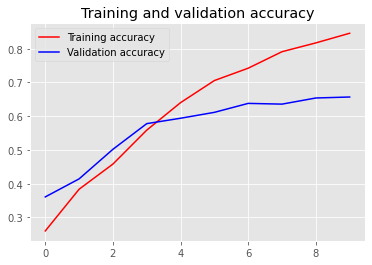

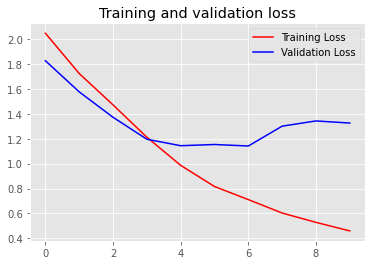

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Save LSTM model

In [61]:
model.save('lstm.h5')

# BERT

So now we will going to make the bert model.In our kernel we have less memory so we will going to take 50% of our dataset

In [62]:
df_bert = df.sample(frac=0.5)

In [63]:
df_bert.reset_index(inplace=True)

In [64]:
df_bert['target'].value_counts()

2    1408
7     880
4     758
8     588
1     563
5     494
6     289
3     288
0     229
Name: target, dtype: int64

So our dataset is imbalanced, we split the dataset in a stratified way

In [65]:
X_train, X_val, y_train, y_val = train_test_split(df_bert.index.values, 
                                                  df_bert.target.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_bert.target.values)

In [66]:
df_bert['data_type'] = ['not_set']*df_bert.shape[0]

df_bert.loc[X_train, 'data_type'] = 'train'
df_bert.loc[X_val, 'data_type'] = 'val'

Now we will construct the BERT Tokenizer.Based on wordpiece.We will intantiate a pre-trained model configuration to encode our data

In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

- To convert all the titles from text into encoded form, we use a function called *batch_encode_plus* and we will proceed train and test data seperately.The first parameter inside the function is the text.
- *add_special_tokens = True* means the sequences will encoded with the special tokens realtive to their model
- *return_attention_mask=True* returns the attention mask according to the special tokenizer defined by *max_length* attribute

In [68]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='train'].final_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='val'].final_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_bert[df_bert.data_type=='train'].target.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_bert[df_bert.data_type=='val'].target.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2074: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Now we got encoded dataset, we can create training data and validation data

In [69]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [70]:
# length of training and validation data 
len(dataset_train), len(dataset_val)

(4672, 825)

We are treating each title as its unique sequence, so one sequence will be classified into one of the 12 labels

In [71]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=12,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataLoader combines a dataset and a sampler and provides an iterable over the given dataset.

In [72]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [73]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [74]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

We will use f1 score as a performance metrics

In [75]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [76]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


### Training loop

In [78]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [79]:
for epoch in tqdm(range(1, epochs+1)):
    
    #model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1558 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 625.83 MiB already allocated; 37.75 MiB free; 692.00 MiB reserved in total by PyTorch)